In [105]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
%matplotlib inline  

   agent_id  day  hour  quarter  ss_id  ss_travel_time
0       142    2     3        0      0      135.932944
1      2831    2     3        0      0      885.287283
2      5681    2     3        0      0      663.670699
3      2964    2     3        0      0      856.263192
4      1571    2     3        0      0      641.284338
   hour quarter ss_travel_time            
                          mean         std
0     3       0     763.132006  170.831193
1     3       1     605.991269  283.903425
2     3       2     607.811875  286.825197
3     3       3     602.811235  292.365642
4     4       0     634.990824  277.885300
5     4       1     617.872416  283.306276
6     4       2     614.699233  285.925178
7     4       3     611.293474  286.972280
8     5       0     678.590264  255.674609
9     5       1     615.642471  283.823631
10    5       2     614.387304  284.717795
11    5       3     619.450619  284.348711


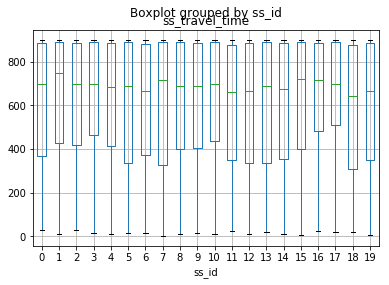

In [106]:
### histogram of travel time
travel_time_df = pd.read_csv('output/travel_time_df/travel_time_r0.csv')
print(travel_time_df.head())

print(travel_time_df.groupby(['hour', 'quarter']).agg({'ss_travel_time': [np.mean, np.std]}).reset_index())

ss_travel_time_df = travel_time_df[(travel_time_df['day'] == 2) 
                                & (travel_time_df['hour'] == 5) 
                                & (travel_time_df['quarter'] == 3)]
ss_travel_time_grp = ss_travel_time_df.boxplot(column='ss_travel_time', by='ss_id')

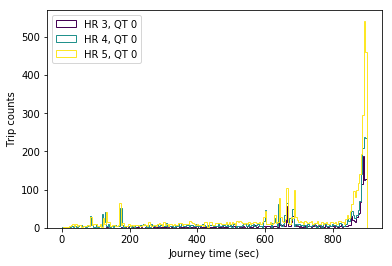

In [107]:
### Journey time for each truncated journey in each assignment period
fig, ax = plt.subplots()
color = iter(cm.viridis(np.linspace(0, 1, 3)))
### distribution of travel time within a period by sub-step
### assumption is that the later the sub-step, the longer the travel time
for hour in range(3, 6):
    for quarter in range(0, 1):
        c = next(color)
        travel_time_quarter_df = travel_time_df[(travel_time_df['day'] == 2) 
                                           & (travel_time_df['hour'] == hour) 
                                           & (travel_time_df['quarter'] == quarter)]
        ax.hist(travel_time_quarter_df['ss_travel_time'], bins=200, 
                histtype='step', fill=False, edgecolor=c, label='HR {}, QT {}'.format(hour, quarter))
plt.xlabel('Journey time (sec)')
plt.ylabel('Trip counts')
plt.legend(loc='upper left')
plt.show()

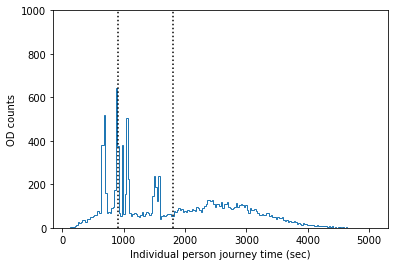

622.8197995022102 647.6086263185304 
     node_osmid_O  node_osmid_D  count
19      65310547     252992433    313 

647.6086263185304 672.3974531348505 
     node_osmid_O  node_osmid_D  count
57     252992403     645559609    300 

672.3974531348505 697.1862799511706 
     node_osmid_O  node_osmid_D  count
1       65284849     252992433    257
59     252992403      65286997    189 

870.7080676654115 895.4968944817316 
      node_osmid_O  node_osmid_D  count
2        65282392     645559609     14
4        65284849     295487932     59
5        65284849     645559609     84
100      65310547      65286997     37
101      65310547     295487932     71
244     252992403     295487932     30 

969.863374930692 994.6522017470121 
    node_osmid_O  node_osmid_D  count
1      65282392      65286997    161
2      65284849     295487932    150 

1044.2298553796522 1069.0186821959724 
     node_osmid_O  node_osmid_D  count
1       65284849     645559609    214
30      65310547      65286997    2

In [128]:
### Journey time distribution per agent
travel_time_od = travel_time_df.groupby('agent_id').agg({'ss_travel_time': np.sum}).reset_index()
bin_cnt, bin_loc, bin_obj = plt.hist(travel_time_od['ss_travel_time'], bins=200, histtype='step', fill=False)
plt.axvline(x=900, color='black', linestyle=':')
plt.axvline(x=1800, color='black', linestyle=':')
plt.xlabel('Individual person journey time (sec)')
plt.ylabel('OD counts')
plt.ylim([0, 1000])
plt.show()

### get the osmid of agent start and end
OD_HR3 = pd.read_csv('output/OD/OD_DY2_HR3.csv')
OD_HR4 = pd.read_csv('output/OD/OD_DY2_HR4.csv')
OD_HR5 = pd.read_csv('output/OD/OD_DY2_HR5.csv')
OD_HR345 = pd.concat([OD_HR3, OD_HR4, OD_HR5], sort=False)
OD_HR345['node_id_igraph_O'] = OD_HR345['origin_sp']-1
OD_HR345['node_id_igraph_D'] = OD_HR345['destin_sp']-1
nodes_df = pd.read_csv('../0_network/data/sf_overpass/nodes.csv')
OD_HR345 = pd.merge(OD_HR345, nodes_df[['node_id_igraph', 'node_osmid']], 
                    left_on='node_id_igraph_O', right_on='node_id_igraph', how='left')
OD_HR345 = pd.merge(OD_HR345, nodes_df[['node_id_igraph', 'node_osmid']], 
                    left_on='node_id_igraph_D', right_on='node_id_igraph', how='left', suffixes=['_O', '_D'])

bin_pairs = [b for b in zip(bin_loc, bin_loc[1:])]
high_freq_bin_pairs = [bin_pairs[i] for i in np.where(bin_cnt>200)[0]]
for (bin_left, bin_right) in high_freq_bin_pairs:
    high_freq_travel_time_od = pd.DataFrame([], columns=['agent_id', 'ss_travel_time'])
    if ~(bin_left<900<bin_right) and ~(bin_left<1800<bin_right):
        high_freq_travel_time_od = pd.concat([high_freq_travel_time_od, 
                                              travel_time_od[(travel_time_od['ss_travel_time']<bin_right)
                                                            & (travel_time_od['ss_travel_time']>bin_left)]],
                                            sort=False)

        high_freq_travel_time_od = pd.merge(high_freq_travel_time_od, 
                                            OD_HR345[['agent_id', 'node_osmid_O', 'node_osmid_D']], 
                                    on='agent_id', how='left')
        high_freq_travel_time_od_grp = high_freq_travel_time_od.groupby(
            ['node_osmid_O', 'node_osmid_D']).size().reset_index().rename(columns={0: 'count'})
        print(bin_left, bin_right, '\n', 
              high_freq_travel_time_od_grp[high_freq_travel_time_od_grp['count']>10], '\n')

,random_seed,day,hour,quarter,quarter_demand,including_residual,producing_residual,avg_min,avg_km,max10_vol,hour_quarter
0,0,2,3,0,1476,0,755,12.712086,7.894311,192.4,3.00
1,0,2,3,1,2253,755,799,10.090773,6.288161,215.7,3.25
2,0,2,3,2,2328,799,809,10.121901,6.266454,220.5,3.50
3,0,2,3,3,2283,809,808,10.037416,6.186871,220.3,3.75
4,0,2,4,0,2781,808,1078,10.569199,6.336556,267.3,4.00


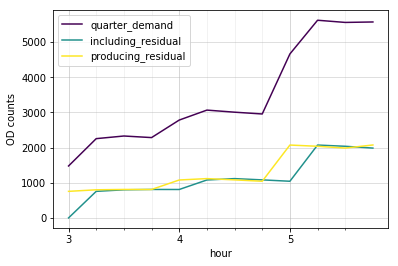

In [140]:
### OD counts plot
summary_df = pd.read_csv('output/summary_df/summary.csv')
summary_df['hour_quarter'] = summary_df['hour'] + summary_df['quarter']*0.25

fig, ax = plt.subplots()
color = iter(cm.viridis(np.linspace(0, 1, 3)))
for item in ['quarter_demand', 'including_residual', 'producing_residual']:
    c=next(color)
    ax.plot(summary_df['hour_quarter'], summary_df[item], color=c, label=item)
plt.legend(loc='upper left')
plt.xlabel('hour')
plt.ylabel('OD counts')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(min(summary_df['hour_quarter']), max(summary_df['hour_quarter']), 1)
minor_ticks = np.arange(min(summary_df['hour_quarter']), max(summary_df['hour_quarter']), 0.25)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

summary_df.head()